In [1]:
import numpy as np

import pandas as pd

import quaternion
from scipy.spatial.transform import Rotation as R

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.ndimage

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [2]:
def plot_table(plot_data, value, a, b):
    fig, axs = plt.subplots(3, 2, figsize=(18, 11))
    
    exp_type = data['Status'].unique()[0]
    fig.suptitle('Empirical data in experiment "{}"'.format(exp_type))

    axs[0, 0].plot(plot_data.Time[a:b], plot_data[value][a:b])
    
    if value == 'HeadPosZ':
        axs[0, 1].plot(plot_data.Time[a:b], plot_data['rot_angle_z'][a:b])
        axs[0, 1].set_title('rot_angle_z')
    else:
        axs[0, 1].plot(plot_data.Time[a:b], plot_data['rot_angle_y'][a:b])
        axs[0, 1].set_title('rot_angle_y')
        
    axs[1, 0].plot(plot_data.Time[a:b], plot_data['left_yaw'][a:b])
    axs[1, 1].plot(plot_data.Time[a:b], plot_data['left_pitch'][a:b])
    axs[2, 0].plot(plot_data.Time[a:b], plot_data['right_yaw'][a:b])
    axs[2, 1].plot(plot_data.Time[a:b], plot_data['right_pitch'][a:b])

    axs[0, 0].set_title(value) 
    axs[1, 0].set_title('left_yaw')
    axs[1, 1].set_title('left_pitch')
    axs[2, 0].set_title('right_yaw')
    axs[2, 1].set_title('right_pitch')
    
def plot_iden(data, predict, a, b, side='left'):
    name_1 = '{}_yaw'.format(side)
    name_2 = '{}_pitch'.format(side)
    
    fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    
    exp_type = data['Status'].unique()[0]
    fig.suptitle('Empirical data and identification in experiment "{}"'.format(exp_type))

    axs[0].plot(data['Time'][a:b], data[[name_1]][a:b])
    axs[0].plot(data['Time'][a:b], predict[:,0][a:b])

    axs[1].plot(data['Time'][a:b], data[[name_2]][a:b])
    axs[1].plot(data['Time'][a:b], predict[:,1][a:b])

    axs[0].set_title(name_1)
    axs[1].set_title(name_2)
    
    axs[0].legend(['Imperical data', 'Identification'])
    axs[1].legend(['Imperical data', 'Identification'])

In [3]:
! ls data

data_132574489412995799_.txt      prep_data_132574489412995799_.csv


In [4]:
file_name = 'prep_data_132574489412995799_'

In [5]:
dataset = pd.read_csv('./data/{0}.csv'.format(file_name))

In [6]:
dataset.Status.unique()

array(['Pause', 'SittingLinearFwdBwd', 'SittingLinearLftRgt',
       'SittingLinearClckwise', 'Pause3', 'SittingRotationHead',
       'SittingRotationBody', 'Pause2', 'MovingLinearFwdBwd',
       'MovingLinearLftRgt', 'MovingLinearClockwise', 'Pause4',
       'MovingRotationLegs', 'MovingRotationBody', '14'], dtype=object)

In [7]:
dataset['rot_angle_z_gf']= scipy.ndimage.gaussian_filter(dataset['rot_angle_z'], 2)
dataset['rot_angle_y_gf']= scipy.ndimage.gaussian_filter(dataset['rot_angle_y'], 2)

In [8]:
data = dataset[dataset['Status'] == 'MovingRotationBody']

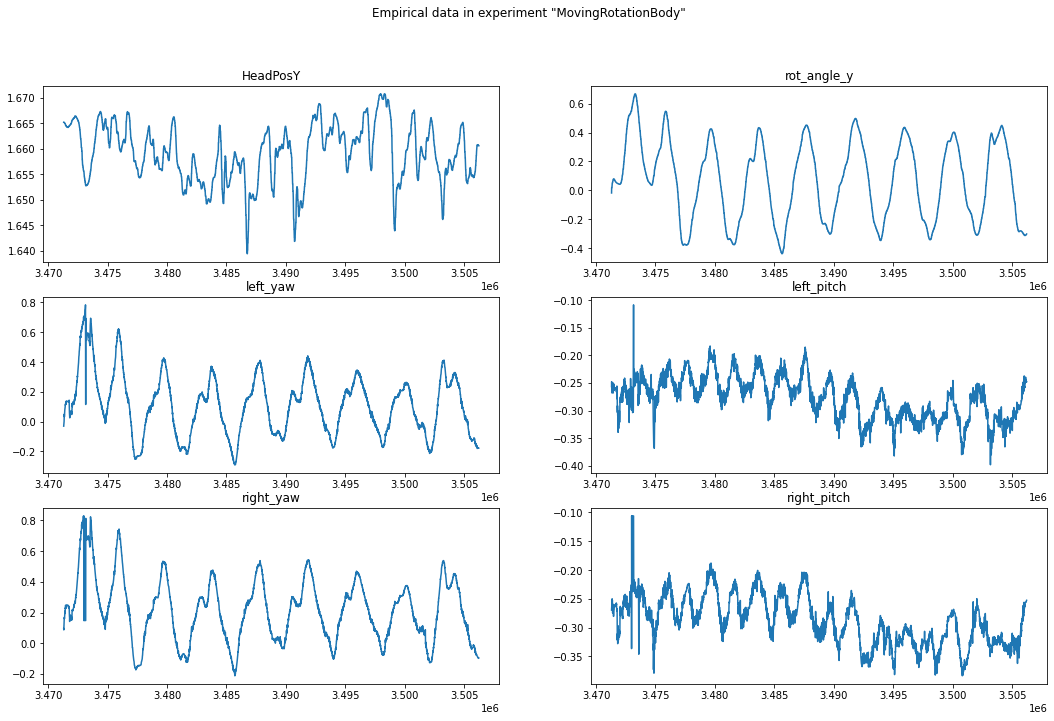

In [9]:
plot_table(data, 'HeadPosY', 100, 15000)

In [10]:
angular_velocity = (data.rot_angle_y_gf.diff() / data.Time.diff()).fillna(0)

angular_acceleration = (angular_velocity.diff() / data.Time.diff()).fillna(0)

linear_acceleration = angular_velocity ** 2

jerk = (angular_acceleration.diff() / data.Time.diff()).fillna(0)

In [11]:
#plt.plot(data['Time'][300:1500], angular_acceleration[300:1500])

In [12]:
#A_s = 0.001 * np.diag([-5,-7,-6])
#B = np.array([0, 0, 1])#.reshape(-3, 1)

In [13]:
def ll_izh(x, nt):

    A = 20 * np.diag([-2, -2])
    P = 1575.9 * np.diag([60, 40])

    n1 = 4
    n2 = 5

    xe = 0.1 * np.ones((nt,n))

    W1 = 20 * np.ones((n,n1))
    W2 = 20 * np.ones((n,n2))

    W1_S = np.ones((nt,n,n1))
    W2_S = np.ones((nt,n,n2))

    W1_S[0] = W1
    W2_S[0] = W2

    sigma1 = np.zeros((nt,1,n1))
    sigma2 = np.zeros((nt,m,n2))

    K1 = 0.1 * np.diag([20, 10])
    K2 = 0.1 * np.diag([20, 10])

    C = 0.1 * np.array([1, 1]).reshape(-3,1)

    a = 0.00002; b = 0.035; c = -0.055; d = 0.05

    v=-0.065*np.ones((nt))  
    u_=0*np.ones((nt))   
    u_[0]=b*v[0]                 
    spiketime=[]
    fired=[]

    for i in range(nt-1):
        v[i+1] = v[i] + Delta_T *(0.04*v[i]*v[i]+5*v[i]+140-u[i]+np.matmul(x[i], C)) 
        u_[i+1] = u_[i] + Delta_T *(a*(b*v[i]-u_[i]))  
        if v[i+1]>0.25:
            v[i+1]=c
            u[i+1]=d
        # Sigma 1
        for j in range(n1):
            #sigma1[0][0][j] = (1 / (1 + 0.22 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.3)

            sigma1[0][0][j] = v[i+1]
            
        
        # Sigma 2
        for j in range(n2):
            for k in range(m):
                #sigma2[k][0][j] = (1 / (1 + 0.2 * np.exp(-0.2 * np.matmul(x[i], C))) - 0.2)
                sigma2[k][0][j] = v[i+1]
        #print(sigma1[0])
        #print(sigma2[0])

        Delta = xe - x 

        xe[i+1] = xe[i] + Delta_T * (np.matmul(A, xe[i]) + np.matmul(W1, sigma1[0][0]) + np.matmul(W2, sigma2[i][0]) * u[i+1])

        W1 = W1 - Delta_T * (np.matmul( np.matmul(K1,P), Delta[i] ).reshape(-3,1) * sigma1[0][0])
        W2 = W2 - Delta_T * (np.matmul( np.matmul(K2,P), Delta[i] ).reshape(-3,1) * u[i+1] * sigma2[i][0])

        # ?? How use for t > TimeSpan ?? 
        W1_S[i+1] = W1
        W2_S[i+1] = W2

    return xe 

In [14]:
nt = data.Time.shape[0]

m = 1
n = 2

Delta_T = 0.01

x = data[['left_yaw', 'left_pitch']].to_numpy()
u = linear_acceleration.to_numpy()

In [15]:
predict = ll_izh(x, nt)

In [16]:
l_yaw_r2 = r2_score(data[['left_yaw']], predict[:,0])
l_pitch_r2 = r2_score(data[['left_pitch']], predict[:,1])

l_yaw_mse = mean_squared_error(data[['left_yaw']], predict[:,0])
l_pitch_mse = mean_squared_error(data[['left_pitch']], predict[:,1])

print(
"""
yaw: r2={0}, mse={1}
pitch: r2={2}, mse={3}
""".format(l_yaw_r2, l_yaw_mse,
           l_pitch_r2, l_pitch_mse))


yaw: r2=0.9876247524872057, mse=0.0005129043114826039
pitch: r2=0.8706047236851666, mse=0.00018585646297471478



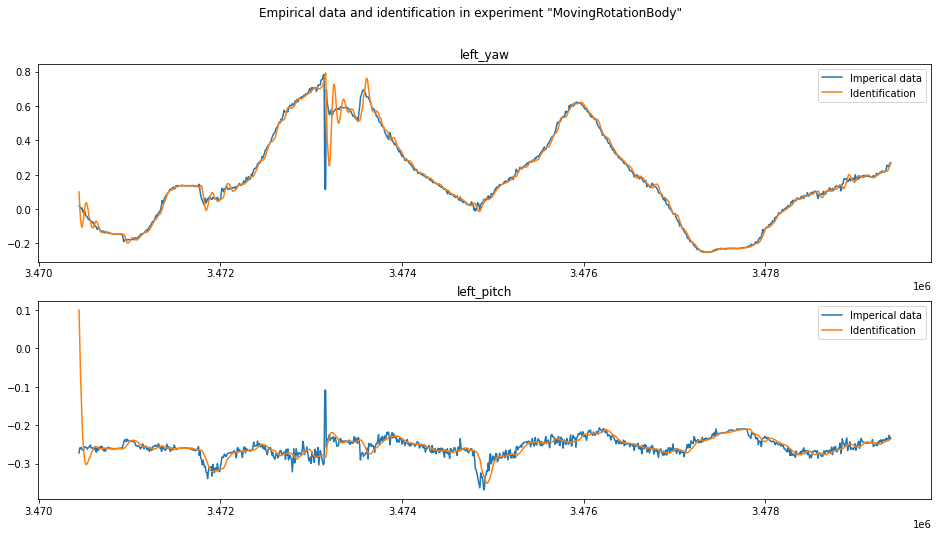

In [17]:
plot_iden(data, predict, 0, 1000)

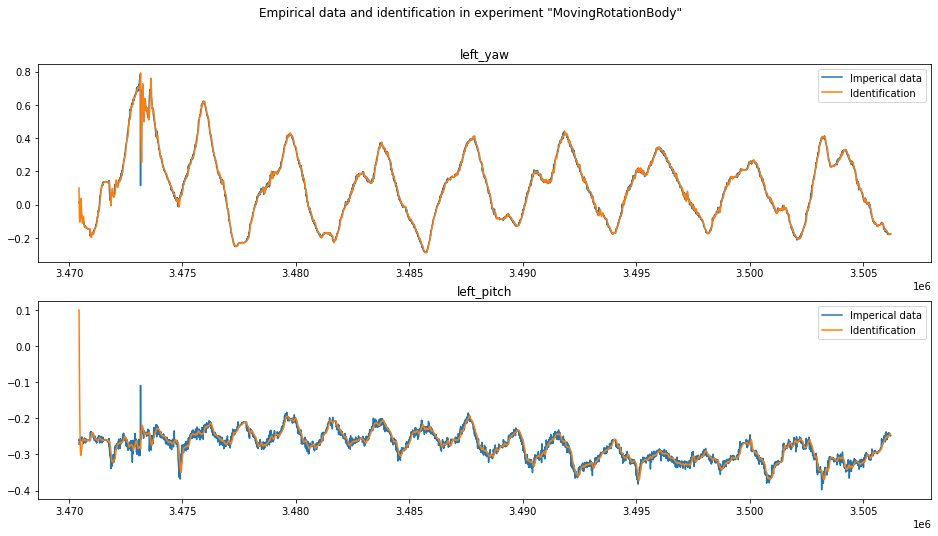

In [18]:
plot_iden(data, predict, 0, 100000)